Welcome to your DataCamp Project audition! This notebook must be filled out and vetted before a contract can be signed and you can start creating your Project.

The first step is forking the repository in which this notebook lives. After that, there are three parts to be completed in this notebook:

- **Project information**:  The title of the Project, a Project description, etc.

- **Project introduction**: The three first text and code cells that will form the introduction of your Project.

- **Rough draft of code for rest of Project:** a rough draft of the remaining code for the rest of your Project (no accompanying text cells required).

When complete, please email the link to your forked repo to projects@datacamp.com with the email subject line _DataCamp Project audition_. If you have any questions, please reach out to projects@datacamp.com.

# Project information

**Project title**: Predicting cancer survival from gene expression

**Name:** Paolo Provero

**Email address associated with your DataCamp account:** paolo.provero@unito.it

**Project description**: 

We will analyze gene expression data from a set of ~300 breast cancer patients and look for correlations between gene expression and survival. Specifically, we will answer questions such as "Are tumors which highly express gene X more aggressive than those with low X expression? Which genes have the strongest power to predict patient survival based on their expression level in the tumors? We will the build a gene signature, that is a set of genes whose expression levels can be used to define a _prognostic score_ to predict patient survival. We will assess the performance of the signature on a _test set_ of tumors not used to build the signature and determine if the signature is a predictor of survival independent of demographic, clinical and histological factors.

You need to be familiar with R at an intermediate level (comfortable writing your own functions and using the _apply_ family of functions), and with basic techniques of survival analysis (i.e. the functions _survfit_, _survdiff_, and _coxph_ from the _survival_ library). Familiarity with transcriptomics (that is, the measurement of gene expression at the whole-genome scale) is useful but not strictly necessary.

The data used in this project are taken from two publications (van’t Veer et al., _Nature_ 415:230, 2002; van de Vijver et al., _NEJM_ 347:1999, 2002). They have been packaged into a Bioconductor library (_breastCancerNKI_). The data contain (1) gene expression data for ~24,000 microarray features and 337 breast cancer patients (2) annotation of the features to human genes, and (3) clinical data about the patients, including survival, demographic and histological data  


# Project introduction

***Note: nothing needs to be filled out in this cell. It is simply setting up the template cells below.***

The final output of a DataCamp Project looks like a blog post: pairs of text and code cells that tell a story about data. The text is written from the perspective of the data analyst and *not* from the perspective of an instructor on DataCamp. So, for this blog post intro, all you need to do is pretend like you're writing a blog post -- forget the part about instructors and students.

Below you'll see the structure of a DataCamp Project: a series of "tasks" where each task consists of a title, a **single** text cell, and a **single** code cell. There are 8-12 tasks in a Project and each task can have up to 10 lines of code. What you need to do:
1. Read through the template structure.
2. As best you can, divide your Project as it is currently visualized in your mind into tasks.
3. Fill out the template structure for the first three tasks of your Project.

As you are completing each task, you may wish to consult the Project notebook format in our [documentation](https://instructor-support.datacamp.com/projects/datacamp-projects-jupyter-notebook). Only the `@context` and `@solution` cells are relevant to this audition.

## 1. The NKI dataset

Here we take a first look at the three components of the data: gene expression data, feature annotations, and clinical data.

Gene expression data are contained in a matrix: each row is a feature (that is a probe spotted on the microarray) and each column is a tumor sample (a patient). Gene expression is represented as the $log_2$ of the ratio between the expression of the probe and the expression of the same probe in a common reference sample.   

The feature data are contained in a dataframe with the same number of rows as the expression matrix. For each probe some technical details are specified, and the associated gene according to various databases. In particular, the columns "NCBI.gene.symbol" and "Description" contain the associated gene in the most readable form. 

The clinical data are contained in a dataframe with as many rows as the _columns_ of the expression data, i.e. one row per sample. Various clinical and demographic data are reported for each patient, including three types of survival: _overall survival_ (the observed event is death, reported in the column "e.os", and the time in "t.os"), _recurrence-free survival_ (the observed event is local or distant recurrence of the disease, columns "e.rfs" and "t.rfs"), and _distant metastasis free survival_ (the observed event is distant metastasis, columns "e.dmfs" and "t.dmfs").   



In [11]:
library(breastCancerNKI)
data(nki)
# expression data
expr <- nki@assayData$exprs
# take a look
head(expr[, 1:5])
# feature annotations
feature <- nki@featureData@data
# note that some features are not associated to any gene:
# these derive from expressed sequence tags that do not overlap any currently annotated human gene
head(feature[, c("NCBI.gene.symbol","Description")])
# clinical data
pheno  <- pheno <- nki@phenoData@data
# overall survival data: the time is expressed in days
head(pheno[, c("e.os", "t.os")])

# Code and comments for the first task
# It should consist of up to 10 lines of code (not including comments)
# and take at most 10 seconds to execute on an average laptop.

,NKI_4,NKI_6,NKI_7,NKI_8,NKI_9
Contig45645_RC,-0.215,0.071,0.182,-0.343,-0.134
Contig44916_RC,-0.207,0.055,0.077,0.302,0.051
D25272,-0.158,-0.010,0.059,0.169,-0.007
J00129,-0.819,-0.391,-0.624,-0.528,-0.811
Contig29982_RC,-0.267,-0.310,-0.120,-0.447,-0.536
Contig26811,0.229,0.157,0.120,0.283,-0.112


,NCBI.gene.symbol,Description
Contig45645_RC,GREM2,"gremlin 2, cysteine knot superfamily, homolog (Xenopus laevis)"
Contig44916_RC,SUHW2,suppressor of hairy wing homolog 2 (Drosophila)
D25272,NA,NA
J00129,FGB,fibrinogen beta chain
Contig29982_RC,SCARA5,"scavenger receptor class A, member 5 (putative)"
Contig26811,NA,NA


,e.os,t.os
NKI_4,0,4744
NKI_6,0,4072
NKI_7,0,3700
NKI_8,0,3213
NKI_9,0,3757
NKI_11,0,2119


## 2. Survival of breast cancer patients

Since these are _consecutive_ patients (that is, all patients treated in a hospital in a given time period) they can be taken to represent the _population_ of breast cancer patients (or at least of those treated in this hospital). Therefore we can use the survival data to estimate the _cumulative probability of survival_ of this population, that is the probability that the event(death, or recurrence, or distant metastasis) has _not_ occurred, as a function of the time elapsed.

We can do this for overall survival, recurrence-free survival, and distant metastasis-free survival. Since death from cancer in most cases occurs due to recurrence and/or metastases, these curves look quite similar to each other.



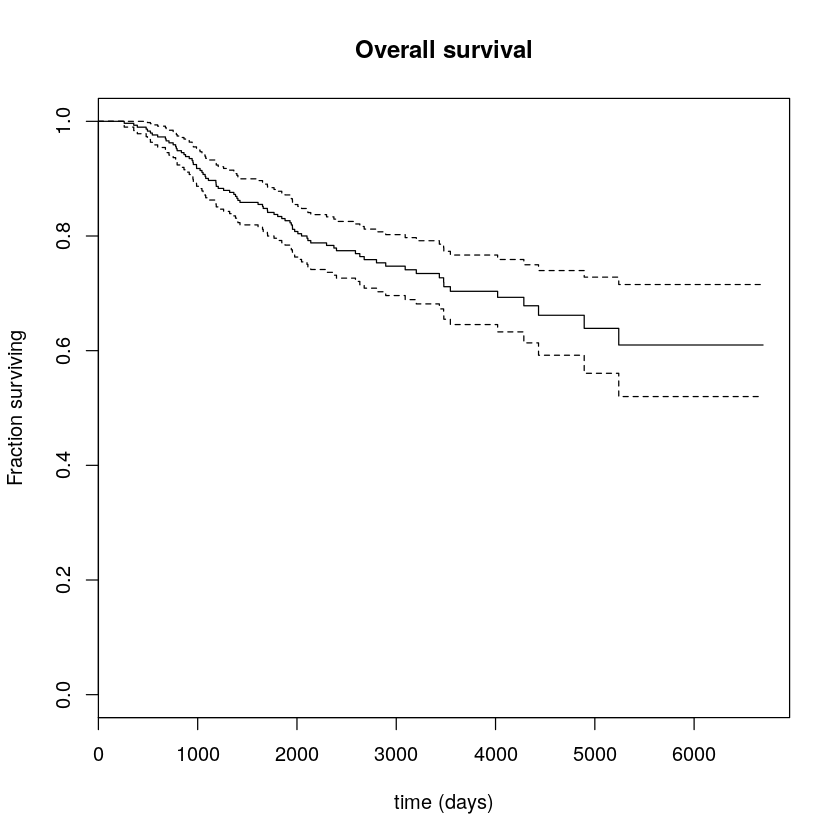

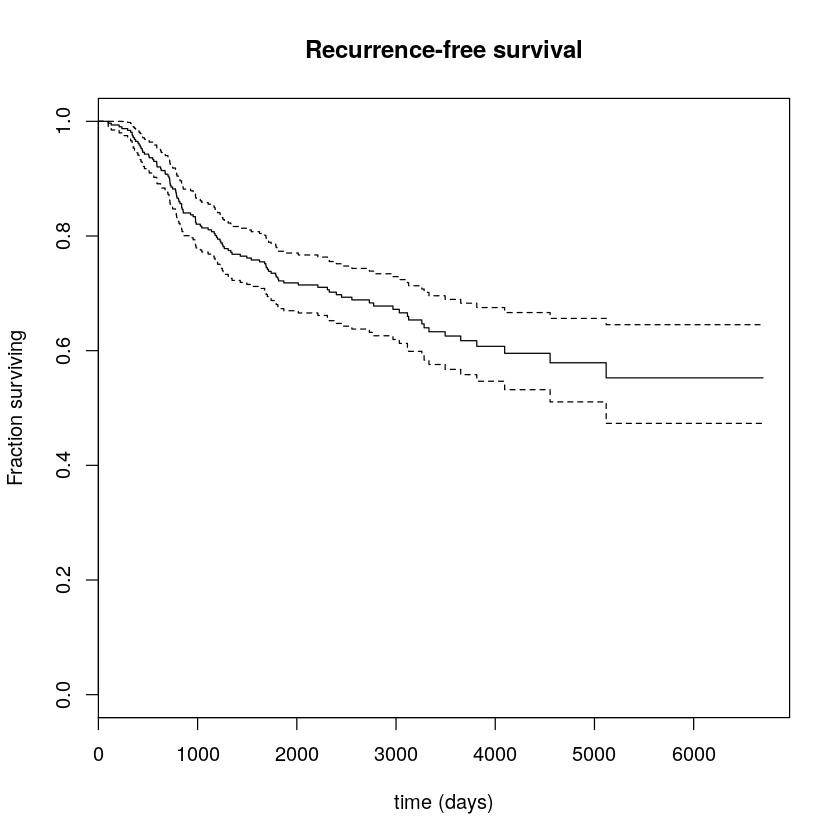

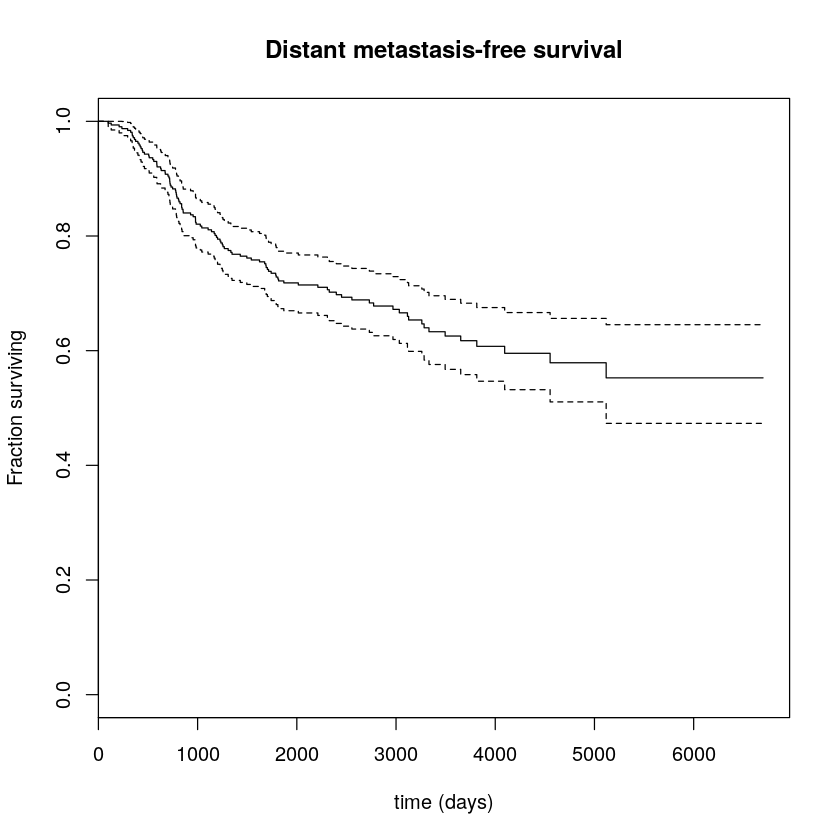

In [12]:
# create a survival object using overall survival:
library(survival)
surv.os <- Surv(time = pheno$t.os, event = pheno$e.os)
# plot the cumulative probability of survival and its confidence interval
plot(surv.os, xlab = "time (days)", ylab = "Fraction surviving", main = "Overall survival")
# same for recurrence-free survival and distant metastasis-free survival
surv.rfs <- Surv(time = pheno$t.rfs, event = pheno$e.rfs)
plot(surv.rfs, xlab = "time (days)", ylab = "Fraction surviving", main = "Recurrence-free survival")
surv.dmfs <- Surv(time = pheno$t.dmfs, event = pheno$e.dmfs)
plot(surv.dmfs, xlab = "time (days)", ylab = "Fraction surviving", main = "Distant metastasis-free survival")




## 3. Expression of the FOXM1 gene

Here we will consider a specific gene (_FOXM1_) and extract its expression values in the patients. Later we will determine if _FOXM1_ expression correlates with patient survival. We could have chosen any gene for this example, but _FOXM1_ seems interesting as it has been recently suggested to be relevant in breast cancer (see e.g. Lu et al., _Oncotarget_ 9:842 (2017)). 

This type of analysis is performed when you are interested, for any reason, in a particular gene and you want to know whether, in particular, its expression is relevant to cancer. Later we will perform a genome-wide analysis in which we will not choose the gene _a priori_, but instead we will analyze the correlation with survival of (virtually) all genes. 

_FOXM1_ has only one associated feature in the microarray, which we will use. Other genes are associated to multiple probes: In this case one can either average over the features or choose the most variable one to obtain a single expression profile for the gene.  

[1] 1

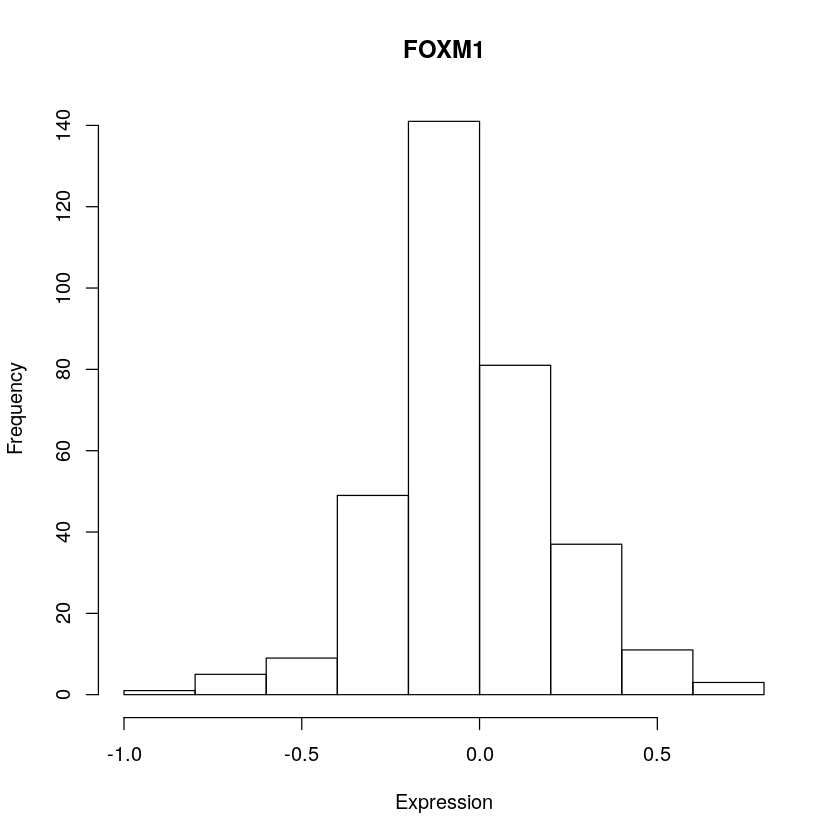

In [13]:
# the "probe" and "NCBI.gene.symbol" columns in the feature dataframe are factors. 
# It is convenient to transform them into character 
feature$probe <- as.character(feature$probe)
feature$NCBI.gene.symbol <- as.character(feature$NCBI.gene.symbol)
# Find the probe(s) associated to FOXM1
foxm1_probe <- feature[which(feature$NCBI.gene.symbol == "FOXM1"), "probe"]
# Luckily there is only one:
length(foxm1_probe)
# Extract the expression
foxm1_expr <- expr[foxm1_probe,]
# Look at its distribution: it looks nice and normal, thanks to the logarithmic transformation of the expression data
hist(foxm1_expr, xlab = "Expression", main = "FOXM1")


# FOXM1 and survival



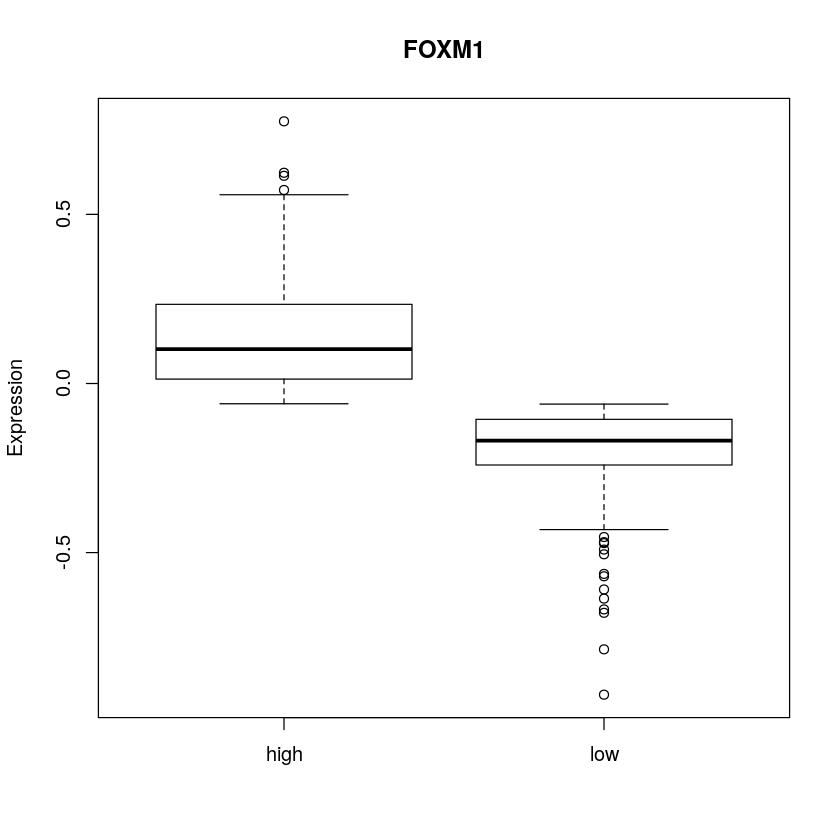

Call:
survdiff(formula = surv.rfs ~ foxm1_status)

n=319, 18 observations deleted due to missingness.

                    N Observed Expected (O-E)^2/E (O-E)^2/V
foxm1_status=high 153       70     44.6      14.5      24.7
foxm1_status=low  166       39     64.4      10.0      24.7

 Chisq= 24.7  on 1 degrees of freedom, p= 7e-07 

Call:
coxph(formula = surv.rfs ~ foxm1_expr)

             coef exp(coef) se(coef)     z        p
foxm1_expr 1.8198    6.1709   0.4086 4.454 8.43e-06

Likelihood ratio test=18.87  on 1 df, p=1.397e-05
n= 319, number of events= 109 
   (18 observations deleted due to missingness)

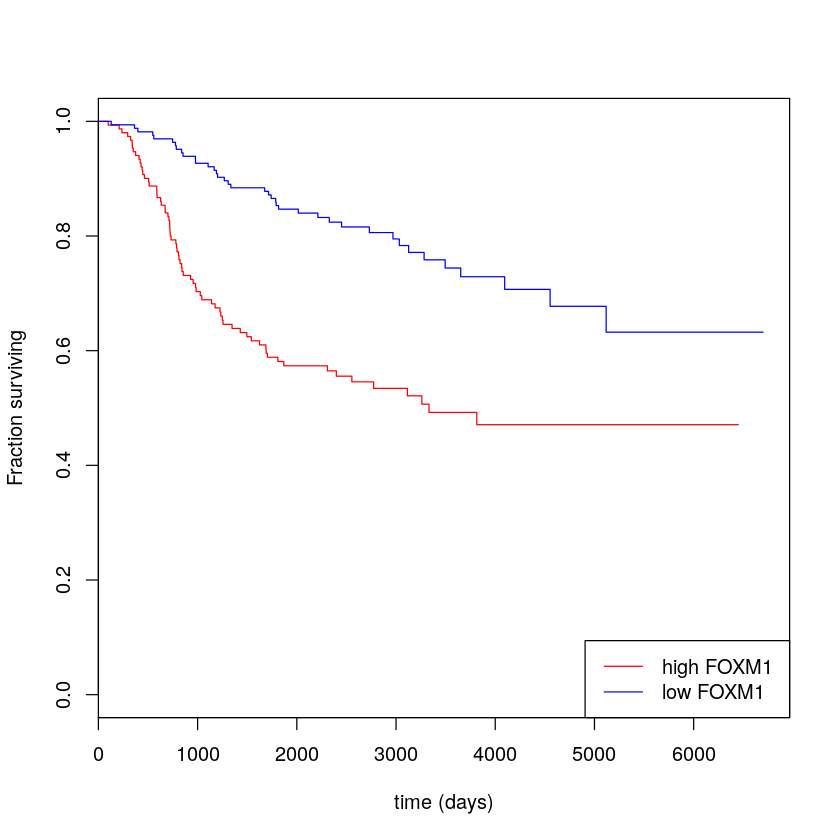

In [14]:
# divide patients into high- and low- FOXM1 expression
foxm1_status <- ifelse(foxm1_expr > median(foxm1_expr), "high", "low")
# sanity check
boxplot(foxm1_expr ~ foxm1_status, main = "FOXM1", ylab = "Expression")
# plot the cumulative survival probabilities of the two groups separately
# we use recurrence-free survival as the data are more complete than for overall survival
plot(survfit(surv.rfs ~ foxm1_status), col = c("red", "blue"), xlab = "time (days)", ylab = "Fraction surviving")
legend(x = "bottomright", col = c("red", "blue"), legend = paste( c("high", "low"), "FOXM1"), lty = 1)

# is the difference statistically significant?
survdiff(surv.rfs ~ foxm1_status)
# is FOXM1 expression, considered as a continuous variable, significantly associatied to survival?
coxph(surv.rfs ~ foxm1_expr)



# Prepare expression values for transcriptome-wide analysis

In [15]:
# count the number of missing values for all features
n.na <- rowSums(is.na(as.data.frame(expr)))
# limit the analysis to features without missing values
expr <- expr[which(n.na == 0), ]
# compute the satndard deviation for each feature
sd <- apply(expr, 1, sd)
# limit the analysis to the 2000 features most variable across samples
expr <- expr[order(sd, decreasing = TRUE),]
expr <- head(expr, n = 2000)


# Prepare training and test sets

In [16]:
# set the random seed for reproducibility
set.seed(1)
# choose 237 samples for training and the remaining 100 for testing
train_samples <- sample(x = 1:ncol(expr), size = 237, replace = FALSE)
# build separate training and testing datasets 
expr_train <- expr[, train_samples]
pheno_train <- pheno[train_samples,]
surv_train <- Surv(time = pheno_train$t.rfs, event = pheno_train$e.rfs)
expr_test <- expr[, -train_samples]
pheno_test <- pheno[-train_samples,]
surv_test <- Surv(time = pheno_test$t.rfs, event = pheno_test$e.rfs)


# Cox analysis training set

In [17]:
# define a function to extract z and p_value from Cox analysis
do_cox <- function(surv, x) {summary(coxph(surv ~ x))$coefficients[1,4:5]}
# perform Cox analysis in the training set on all features 
cox <- t(apply(expr_train, 1, do_cox, surv = surv_train))
colnames(cox)[2] <- "p_value"
# add information about the genes associated to the features
cox <- merge(cox, feature[, c("NCBI.gene.symbol", "Description")], by = 0)
# order by p-value
cox <- cox[order(cox[, "p_value"]), ]
# show the top ten features by significance
head(cox, n = 10)


Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; beta may be infinite. ”

,Row.names,z,p_value,NCBI.gene.symbol,Description
1669,NM_006399,-4.830132,1.364424e-06,BATF,"basic leucine zipper transcription factor, ATF-like"
56,AF007153,-4.741984,2.116350e-06,ERBB4,v-erb-a erythroblastic leukemia viral oncogene homolog 4 (avian)
1472,NM_003981,4.431069,9.376710e-06,PRC1,protein regulator of cytokinesis 1
523,Contig3464_RC,-4.265520,1.994373e-05,NA,NA
981,Contig63649_RC,4.199312,2.677269e-05,NA,NA
1577,NM_005235,-4.066479,4.772871e-05,ERBB4,v-erb-a erythroblastic leukemia viral oncogene homolog 4 (avian)
1187,NM_001360,4.051392,5.091383e-05,DHCR7,7-dehydrocholesterol reductase
955,Contig57584_RC,4.024828,5.701693e-05,CDCA3,cell division cycle associated 3
1104,NM_000582,4.013389,5.985321e-05,SPP1,"secreted phosphoprotein 1 (osteopontin, bone sialoprotein I, early T-lymphocyte activation 1)"
1183,NM_001333,4.005978,6.176140e-05,CTSL2,cathepsin L2


# Gene signature and score

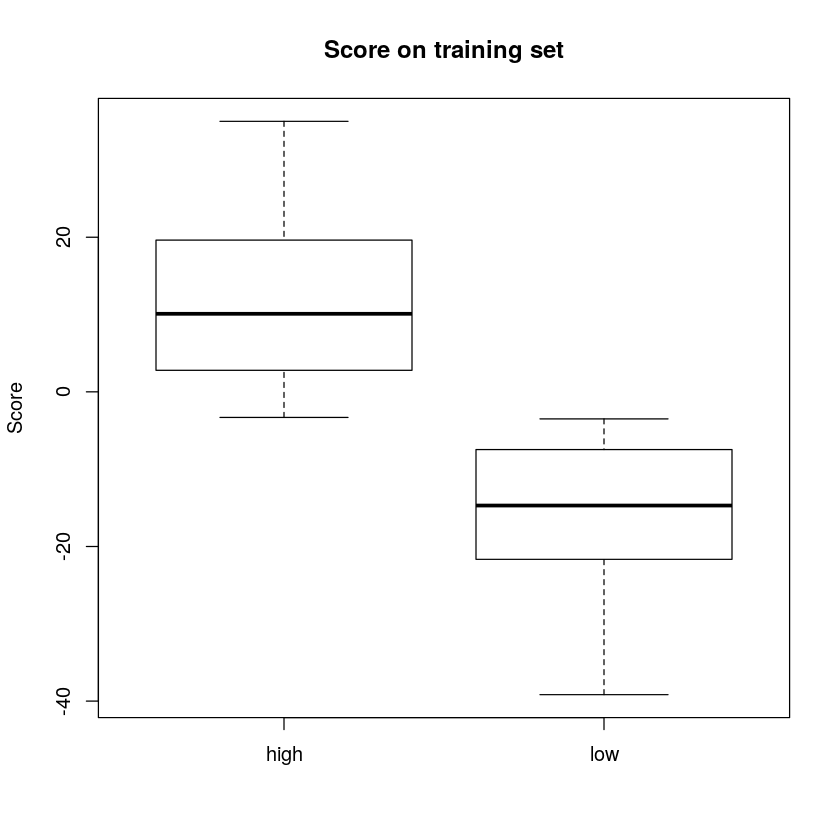

In [18]:
# build a signature using the top 20 features by significance
sig <- head(cox, n = 20)
# consider gene expression limited to the signature features
expr_sig_train <- expr_train[sig$Row.names, ]
# compute the score for each paitient in the training set
score_train <- apply(expr_sig_train, 2, function(x) sum(x * sig$z))
# divide patients in high- and low-score
score_status_train <- ifelse(score_train > median(score_train), "high", "low")
# sanity check...
boxplot(score_train ~ score_status_train, main = "Score on training set", ylab = "Score")


# Score predictivity on test set

Call:
survdiff(formula = surv_test ~ score_status_test)

n=95, 5 observations deleted due to missingness.

                        N Observed Expected (O-E)^2/E (O-E)^2/V
score_status_test=high 39       20     11.6      6.00      8.86
score_status_test=low  56       17     25.4      2.76      8.86

 Chisq= 8.9  on 1 degrees of freedom, p= 0.003 

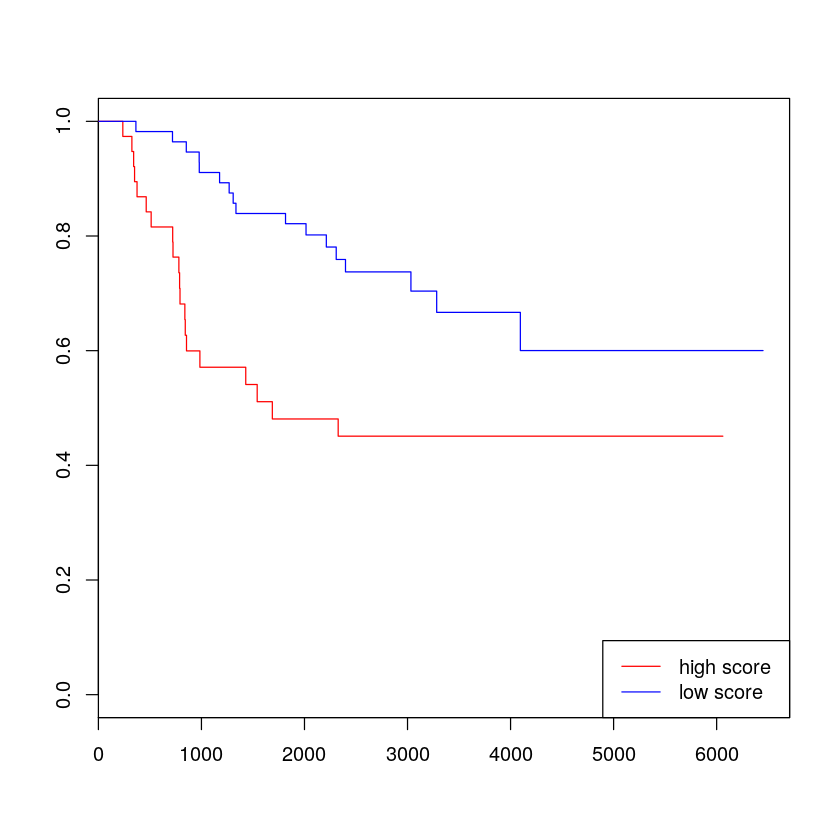

In [19]:
# expression data on test set, limited to signature genes
expr_sig_test <- expr_test[sig$Row.names, ]
# compute the score of test set patients
score_test <- apply(expr_sig_test, 2, function(x) sum(x * sig$z))
# divide test set patients into high- and low-score groups
score_status_test <- ifelse(score_test > median(score_train), "high", "low")
# cumulative survival probabilities of the two groups
plot(survfit(surv_test ~ score_status_test), col = c("red", "blue"))
legend(x = "bottomright", col = c("red", "blue"), legend = paste(c("high", "low"), "score"), lty = 1)
# is the difference statistically significant?
survdiff(surv_test ~ score_status_test)


# Score as an independent predictor

In [20]:
# here we will consider the whole dataset
expr_sig <- expr[sig$Row.names, ]
# compute the score for all patients
score <- apply(expr_sig, 2, function(x) sum(x * sig$z))
# perform multivariate Cox regression using the score and several clinical/demograpohic/histological
# parameters as covariates
summary(coxph(surv.rfs ~ score + pheno$age + pheno$er + pheno$grade + pheno$size + pheno$node + pheno$treatment))


Call:
coxph(formula = surv.rfs ~ score + pheno$age + pheno$er + pheno$grade + 
    pheno$size + pheno$node + pheno$treatment)

  n= 319, number of events= 109 
   (18 observations deleted due to missingness)

                     coef exp(coef)  se(coef)      z Pr(>|z|)    
score            0.049746  1.051004  0.009274  5.364 8.13e-08 ***
pheno$age       -0.067819  0.934429  0.016374 -4.142 3.44e-05 ***
pheno$er         0.755832  2.129383  0.284600  2.656  0.00791 ** 
pheno$grade      0.155809  1.168603  0.165593  0.941  0.34675    
pheno$size       0.151084  1.163095  0.110648  1.365  0.17211    
pheno$node       0.155251  1.167951  0.294443  0.527  0.59801    
pheno$treatment -0.334992  0.715343  0.238569 -1.404  0.16027    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                exp(coef) exp(-coef) lower .95 upper .95
score              1.0510     0.9515    1.0321    1.0703
pheno$age          0.9344     1.0702    0.9049    0.9649
pheno$er           2.129